In [2]:
'''
连续型——Hopfield神经网络求解TSP
1、初始化权值（A,D,U0）
2、计算N个城市的距离矩阵dxy
3、初始化神经网络的输入电压Uxi和输出电压Vxi
4、利用动力微分方程计算：dUxi/dt
5、由一阶欧拉方法更新计算：Uxi(t+1) = Uxi(t) + dUxi/dt * step
6、由非线性函数sigmoid更新计算：Vxi(t) = 0.5 * (1 + th(Uxi/U0))
7、计算能量函数E
8、检查路径是否合法
'''
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#积分运算包
from sympy import *

#反函数包
from pynverse import inversefunc

In [3]:
#求两城市之间的距离
def price_cn(vec1, vec2):
    #linalg  第二范数
    return np.linalg.norm(np.array(vec1) - np.array(vec2))

# 距离矩阵
def get_distance(citys):
    N = len(citys)
    distance = np.zeros((N, N))
    for i, curr_point in enumerate(citys):
        line = []
        [line.append(price_cn(curr_point, other_point)) if i != j else line.append(0.0) for j, other_point in enumerate(citys)]
        distance[i] = line
    return distance

# F(u)
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))


# 输入电压U
def calc_U(U, du, step):
    return U + du * step


# 当前网络的能量
def calc_energy(V, distance):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e

#计算距离
def calc_distance(path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis

# 动态方程计算微分方程du 
def calc_du(V, distance):
    a = np.sum(V, axis=0) - 1 
    b = np.sum(V, axis=1) - 1
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c

# 检查路径的正确性
def check_path(V):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV

#画城市分布图
def draw_citys_location(citys):
    plt.scatter(citys.T[0], citys.T[1])
    plt.show()

In [4]:
#能量函数
def calc_energy_new(V, distance,P=200,Q=500,t = 1,U0 = 0.02):
    S=T=Q
    N = len(V)
    V1 = 0
    V2 = 0
    V3 = 0
    V4 = 0
    V5 = 0
    for x in range(N):
        for i in range(N):
            for j in range(N):
                if j == i:
                    continue
                else:
                    V1 = V1 + S/2*V[x][i]*V[x][j]
    for i in range(N):
        for x in range(N):
            for y in range(N):
                if y == x:
                    continue
                else:
                    V2 = V2 + Q/2*V[x][i]*V[y][i]
            
    for x in range(N):
        for i in range(N):
            V3 = V3 + T/2 * (V[x][i] - N) **2
            
    for x in range(N):
        for i in range(N):
            for y in range(N):
                if y==x:
                    continue
                else:
                    V4 = V4 + P/2 * distance[x][y]*V[x][i]*(V[y,i+1]+V[y, i-1])
    
    for x in range(N):
        for i in range(N):
            x = symbols("x")
            V5 = V5 + integrate(inversefunc(calc_V(x,U0)), (x, 0, V[x][i]))
    

    return V1 + V2 + V3 + V4 + V5    

In [5]:
# 可视化
def draw_H_and_E(citys, H_path, energys, m=1):
    fig = plt.figure()
    # 哈密顿回路
    ax1 = fig.add_subplot(m,2,1)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.02, color='r',alpha = 0.5)
        p2 = plt.Circle(citys[to_], 0.02, color='r', alpha = 0.5)
        ax1.add_patch(p1)
        ax1.add_patch(p2)
        ax1.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='r', alpha = 0.5)
        ax1.annotate(text=chr(97 + to_), xy=citys[to_], xytext=(-4, -4), textcoords='offset points', fontsize=10)
    ax1.axis('equal')
    ax1.grid()
    # 迭代曲线
    ax2 = fig.add_subplot(m,2,2)
    ax2.plot(np.arange(0, len(energys), 1), energys, color='green', alpha = 0.5)
    plt.show()
    

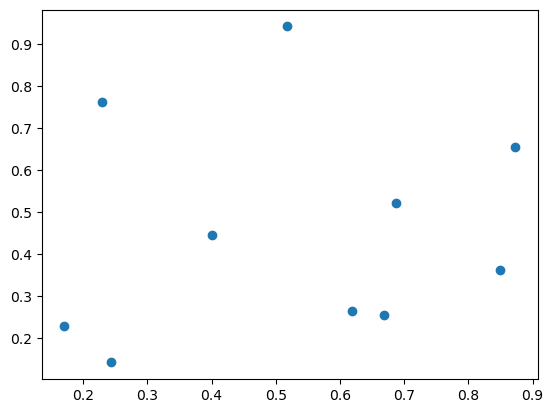

第66次迭代找到的次优解距离为：4.518362817832573，能量为：5.648868960973195，路径为：
d,e,c,g,f,j,i,a,b,h,d


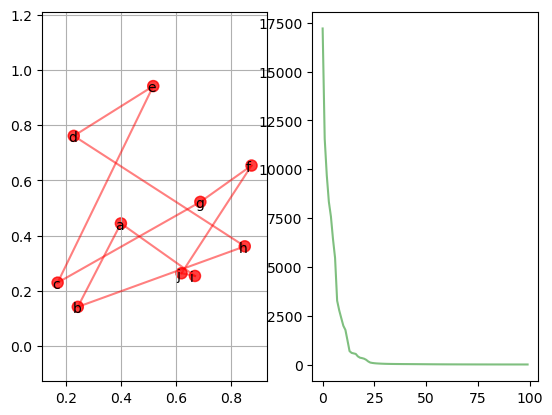

第80次迭代找到的次优解距离为：4.8742146749980995，能量为：3.044233014340942，路径为：
b,a,c,h,i,d,f,e,j,g,b


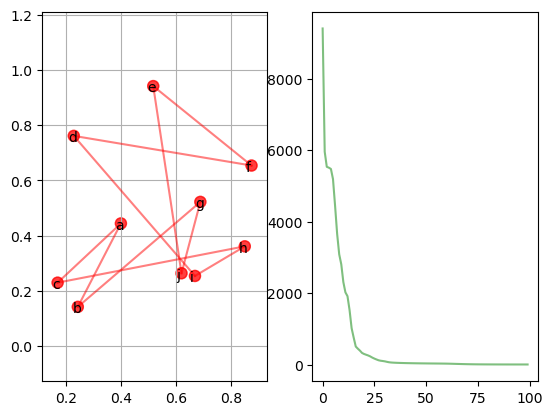

第44次迭代找到的次优解距离为：4.651336701355288，能量为：13.317237584670918，路径为：
a,c,d,g,j,b,i,e,h,f,a


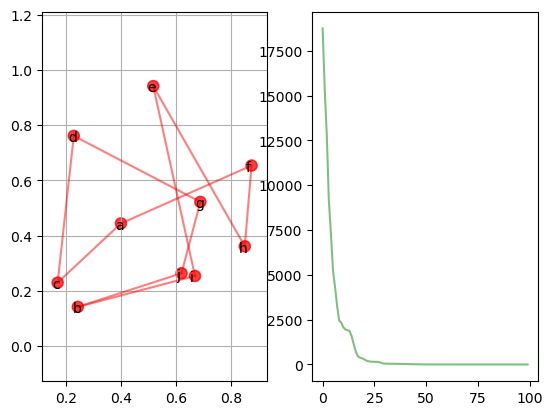

第34次迭代找到的次优解距离为：5.337587277923169，能量为：18.89214893984489，路径为：
e,j,h,d,a,i,c,g,f,b,e


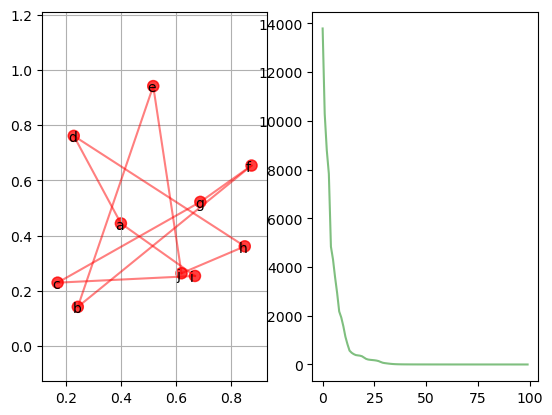

第62次迭代找到的次优解距离为：5.369598655391406，能量为：7.3047153859944025，路径为：
e,h,a,g,i,f,c,d,j,b,e


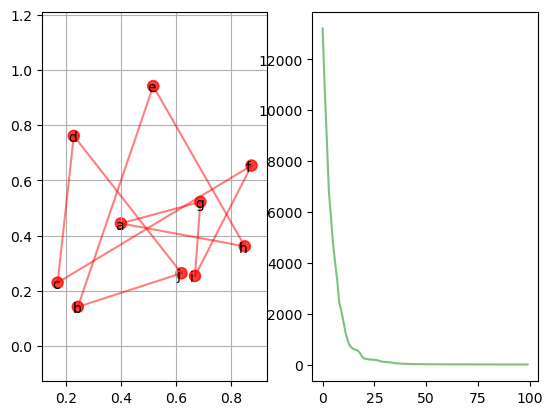

第51次迭代找到的次优解距离为：4.576867708331259，能量为：5.302976911391811，路径为：
j,c,h,d,e,a,f,g,i,b,j


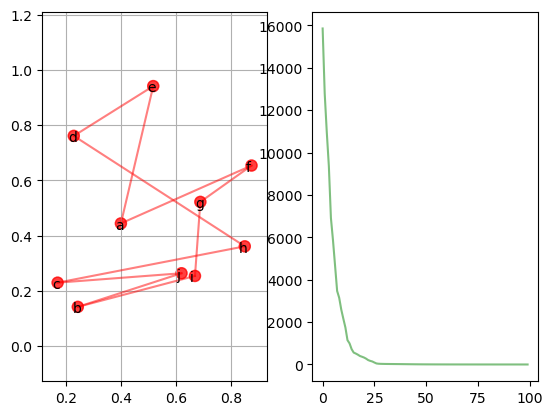

第37次迭代找到的次优解距离为：3.9221394171749835，能量为：11.036803897481297，路径为：
i,f,g,d,e,c,a,b,h,j,i


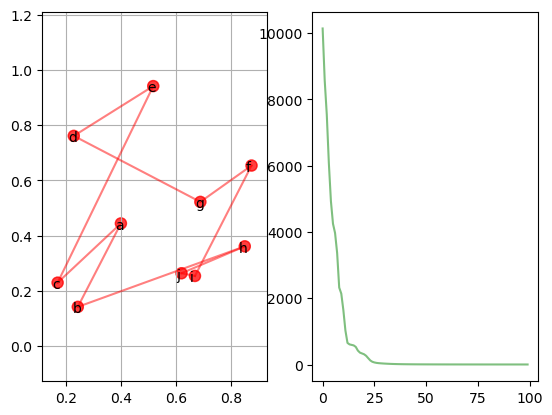

第51次迭代找到的次优解距离为：4.323354781464391，能量为：13.213287111323757，路径为：
b,d,f,h,a,i,g,e,j,c,b


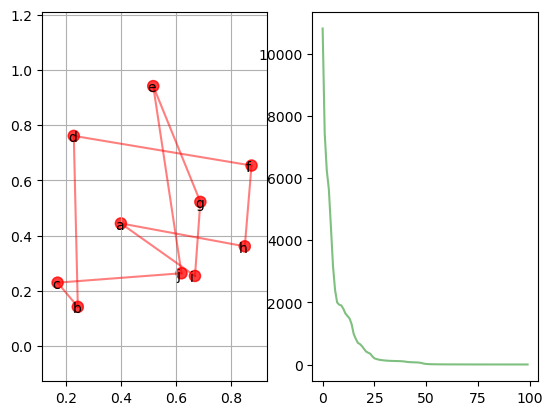

没有找到最优解
第29次迭代找到的次优解距离为：5.162777708209559，能量为：123.97898324034965，路径为：
g,d,h,i,a,b,e,j,c,f,g


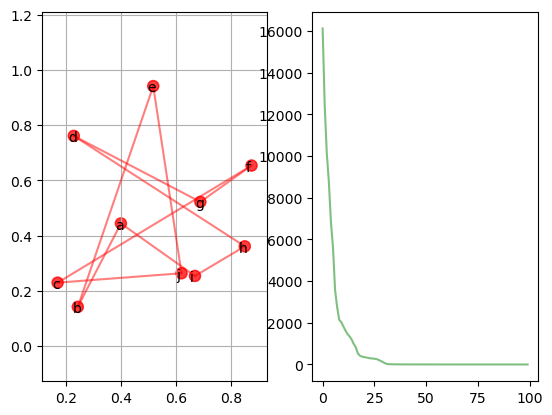

In [6]:
if __name__ == '__main__':
    #初始化城市point
    citys = np.array([[0.4000,0.4439], [0.2439, 0.1416], [0.1707, 0.2293], [0.2293, 0.7610], [0.5171, 0.9414], [0.8732, 0.6536], [0.6878, 0.5219],
                      [0.8488, 0.3609],[0.6683, 0.2536],[0.6195, 0.2634]])
    #画散点图
    draw_citys_location(citys)
    
    #得到城市距离矩阵
    distance = get_distance(citys)
    
    N = len(citys)
    
    
    # 设置初始值
    A = N * N
    D = N / 2
    U0 = 0.02  # 初始电压
    step = 0.0001  # 步长
    num_iter = 100  # 迭代次数
    P = 200
    Q = S = T = 500
    
    initial_num = 10#随机初始化次数

    for i in range(initial_num):
    # 初始化神经网络的输入状态（电路的输入电压U）
        U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)


        # 初始化神经网络的输出状态（电路的输出电压V）
        V = calc_V(U, U0)

        energys = np.array([0.0 for x in range(num_iter)])  # 每次迭代的能量

        best_distance = np.inf  # 最优距离
        best_route = []  # 最优路线

        H_path = []  # 哈密顿回路


        # 开始迭代训练网络
        for n in range(num_iter):

            # 利用动态方程计算du
            du = calc_du(V, distance)

            # 更新下一个时间的输入状态（电路的输入电压U）
            U = calc_U(U, du, step)

            # 由sigmoid函数更新下一个时间的输出状态（电路的输出电压V）
            V = calc_V(U, U0)

            # 计算当前网络的能量E
            energys[n] = calc_energy(V, distance)

            # 检查路径的合法性
            route, newV = check_path(V)

            if len(np.unique(route)) == N:
                route.append(route[0])
                dis = calc_distance(route)
                if dis < best_distance:
                    H_path = []
                    best_distance = dis
                    best_route = route
                    [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
                    print('第{}次迭代找到的次优解距离为：{}，能量为：{}，路径为：'.format(n, best_distance, energys[n]))
                    [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)]
        if len(H_path) > 0:
            draw_H_and_E(citys, H_path, energys)
        else:
            print('没有找到最优解')